https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

1) Describe how topic models define a document. Why is this a useful framework? What substantive questions might it answer? Why isn’t it useful and which questions might it be ill-suited to?

LDA assumes, like humans assume, that words carry strong semantic information and similar documents will use similar words. Secondly, documents are pobability distributions over latent topics and topics are probability distributions over words. 

An important distinction to other models is that LDA works with probability distributions not strict word-frequencies. 

Topic models define a document as a mixture of a small number of topics and its words atrributed to one of the topics. This framework is useful as it allows, for example, genitists to study the genome in an applied way. Another example, engineers, may classify documents and approximate their relation to other topics. 

With plate notation, let's describe the below image: 
- $K$ number of topics
- $M$ number of documents
- $N$ number of words in a given document
- β parameter of Dirichlet prior on per-topic word distro
- $\Phi$ word distribution for topic $K$ (sums to 1)
- $a$ parameter of Dirichlet prior on per-document topic distro
- $\Theta$ topic distro for document 
- $z$ topic word in document
- $w$ specific word

"What substantive questions might it answer?"
Topic models are able to derive 'topics' from uncategorized text, without a human having to read it!

"Why isn't it useful and which questions might it be ill-suit to?"
If your corpus is constantly changing, the sensitive hyper-parameters will need maintenance. If not maintained unintented drift will occur and the derived topics will not be useful.

<img src="../images/lda_k.png">
Source: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

# Setup

The below notebook was built surrounding this tutorial:
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples

In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import re, nltk, spacy, gensim

# sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# misc
from pprint import pprint

# plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
# load data from processed dir
df_game_reviews = pd.read_csv(r'../data/processed/game_reviews_processed.csv')

In [3]:
# clean
# remove all data colums aside from recommendationid, review, and timestamp_created.
def prune_cols(df):
    # keep only needed cols and subset english only
    global df_game_reviews
    df_game_reviews = df_game_reviews.loc[df_game_reviews['language'] == 'english'] # subsets for english
    df_game_reviews = df_game_reviews[["recommendationid", "review", "timestamp_created"]] # dops unnecessary cols
    return df_game_reviews
    
prune_cols(df_game_reviews)

,recommendationid,review,timestamp_created
1,71182712,Game is fun and exciting when it works. Very s...,2020-06-22 11:11:01
5,26578229,Excellent game. \n\nPlenty of fun to be had in...,2016-11-13 04:55:20
7,71178247,Players are too serious and you can't have fun...,2020-06-22 09:22:03
8,71177738,great simulation game,2020-06-22 09:09:17
10,71176801,A blast of a game.\nAlso a blast of a grenade ...,2020-06-22 08:47:18
...,...,...,...
51316,19708009,Communication and teamplay is one of the best ...,2015-12-15 02:02:09
51317,19708002,If you're looking for a realistic mil-sim styl...,2015-12-15 02:01:24
51318,19707993,ITS THE BEST GAME EVERS \n\nPlay this game if ...,2015-12-15 02:00:26
51319,19707992,(Disclaimer: This game used to not be on Steam...,2015-12-15 02:00:24


In [4]:
# send review col to list
reviews = df_game_reviews.review.tolist()

In [5]:
# clean
# remove new line delimeter
def remove_line(reviews):
    temp_lst = []
    for item in reviews:
        item = str(item)
        item = item.replace('\n', ' ')
        temp_lst.append(item)
    
    reviews = temp_lst
    temp_lst = None
    df_game_reviews = None
    return reviews
    
remove_line(reviews); # note: output hidden, because it's a nastly-long block of text. 

# Exploratory Analysis

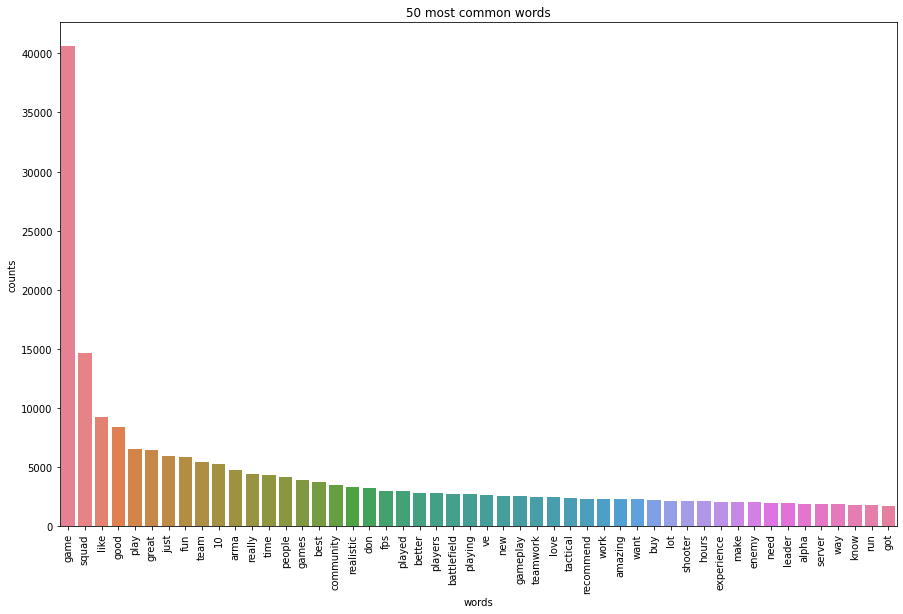

In [6]:
# remove punctuation and make all words lowercase
def rem_punct_and_lower(df):
    temp_lst = ['.','\n','!','@','#','$','%','^','&','*','(',')','<', '>', '?', ':']
    
    for item in temp_lst:
        #parse through temp_lst
        df['review'] = df['review'].str.replace(item, '')
    
    df["review"] = df["review"].str.lower() # covert words to lowercase
    df['review'] = df['review'].astype(str) # convert erraythang to str
    
    return df

rem_punct_and_lower(df_game_reviews)

def plot_50_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:50]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='50 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed reviews
count_data = count_vectorizer.fit_transform(df_game_reviews['review'])
# Visualise the 50 most common words
plot_50_most_common_words(count_data, count_vectorizer)

# Tokenize

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc = True removes punctuations

data_words = list(sent_to_words(reviews))

print(data_words[:1])

[['game', 'is', 'fun', 'and', 'exciting', 'when', 'it', 'works', 'very', 'simple', 'milsim', 'aspects', 'that', 'are', 'much', 'easier', 'to', 'grasp', 'than', 'arma', 'however', 'cannot', 'even', 'play', 'it', 'in', 'it', 'current', 'state', 'every', 'time', 'get', 'into', 'firefight', 'the', 'game', 'locks', 'up', 'and', 'completely', 'freezes', 'my', 'pc', 'more', 'than', 'makes', 'the', 'minimum', 'requirements', 'poor', 'optimization', 'ruins', 'the', 'experience', 'for', 'me', 'can', 'recommend', 'it', 'in', 'it', 'current', 'state']]


# Lemmatization

In [8]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['game fun exciting when work very simple milsim aspect much easy grasp however can even play current state time firefight game lock completely freeze pc more make minimum requirement poor optimization ruin experience can recommend current state', 'excellent plenty fun have game work very well gtx gig could probably use gb game however require solid hour so time willing communicate will simply poor experience play project reality bf will enjoy game pro commucation weapon gunplay map simple control scheme compare con will very frustrating player never play project reality']


# Create Document-Word matrix

In [9]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Check Sparsicity

In [10]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.46320289859969344 %


# Build LDA model and Diagnose performance with perplexit and log-lielihood
(A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.)

### Find 'Best' model parameters
(# Fit LDA with a few different values for K aka n_components. How does the value of K seem to change your results?)

In [11]:
# define Search Param
search_params = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                  11,12,13,14,15,16,17,18,19,20,
                                  21,22,23,24,25,26,27,28,29,30,
                                  31,32,33,34,35,36,37,38,39,40,
                                  41,42,43,44,45,46,47,48,49,50,
                                  51,52,53,54,55,56,57,58,59,60,
                                  61,62,63,64,65,66,67,68,69,70,
                                  71,72,73,74,75,76,77,78,79,80,
                                  81,82,83,84,85,86,87,88,89,90,
                                  91,92,93,94,95,96,97,98,99,100] #number of topics
                }

# init the Model
lda = LatentDirichletAllocation(doc_topic_prior=None,
                                evaluate_every=-1,
                                learning_decay=0.7,
                                learning_offset=10.0,
                                max_doc_update_iter=100,
                                max_iter=10,
                                mean_change_tol=0.001,
                                n_components=5,
                                n_jobs=-1,
                                perp_tol=0.1, 
                                random_state=42,
                                topic_word_prior=None, 
                                total_samples=1000000.0, 
                                verbose=0
                               )

# init Grid Search Class
model = GridSearchCV(cv = None,
                     estimator=lda, 
                     param_grid=search_params,
                     pre_dispatch='2*n_jobs',
                     refit = True,
                     scoring = None,
                     verbose = 0,
                     n_jobs = 1,
                     return_train_score = 'warn'
                    )

# do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(n_components=5, n_jobs=-1,
                                                 random_state=42),
             n_jobs=1,
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             return_train_score='warn')

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

#previous runs:

#Best Model's Params:  {'n_components': 1}
#Best Log Likelihood Score:  -849166.1577512659
#Model Perplexity:  698.6306022156406

#Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
#Best Log Likelihood Score:  -849166.1577512659
#Model Perplexity:  698.6306022156406

Best Model's Params:  {'n_components': 1}
Best Log Likelihood Score:  -849166.1577512659
Model Perplexity:  698.6306022156406


# Fit LDA with a few different values for K. How does the value of K seem to change your results?
(the increase of K's value, decreased the model's strength)

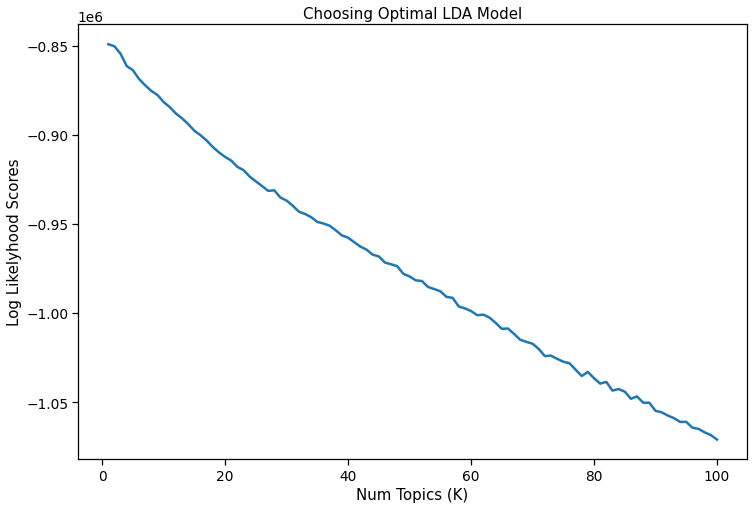

In [13]:
#plot of learning optimal params
def plot_scores(model):
    temp_params = []
    temp_mean_test_score = []
    n_topics = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                11,12,13,14,15,16,17,18,19,20,
                21,22,23,24,25,26,27,28,29,30,
                31,32,33,34,35,36,37,38,39,40,
                41,42,43,44,45,46,47,48,49,50,
                51,52,53,54,55,56,57,58,59,60,
                61,62,63,64,65,66,67,68,69,70,
                71,72,73,74,75,76,77,78,79,80,
                81,82,83,84,85,86,87,88,89,90,
                91,92,93,94,95,96,97,98,99,100] # K 

    for item in model.cv_results_['mean_test_score']:
        temp_mean_test_score.append(item)
    
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, temp_mean_test_score)
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics (K)")
    plt.ylabel("Log Likelyhood Scores")
    #plt.legend(title='Learning decay', loc='best')
    plt.show()

plot_scores(model)

# Dominant Topic in each Document
(note: because there is only 1 topic, this section becomes irrelevant. I'm leaving it in here because I might change topic count)

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(reviews))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,dominant_topic
Doc0,1.000000,0
Doc1,1.000000,0
Doc2,1.000000,0
Doc3,1.000000,0
Doc4,1.000000,0
Doc5,1.000000,0
Doc6,1.000000,0
Doc7,1.000000,0
Doc8,1.000000,0
Doc9,1.000000,0


# Visualize LDA Model
(this section is also not used due to topic count)

Here's an example of the graphic: https://user-images.githubusercontent.com/20510239/28708365-9d274b3a-73ae-11e7-805f-6c65adbd4907.png

In [15]:
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
#panel

# Using your knowledge of the corpus, choose the best value for K and justify this result substantively. Fit a topic model with this value, interpret it substantively as it relates to your research question, and write these results up:

# Inspect Topic Keywords

In [16]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aas,abandon,ability,abit,able,abrams,absolute,absolutely,absolutly,...,year,yell,yelling,yesterday,young,youtube,youtuber,zombie,zone,zoom
Topic0,101.0,37.0,58.0,226.0,25.0,720.0,22.0,152.0,531.0,34.0,...,1209.0,314.0,36.0,36.0,58.0,132.0,21.0,24.0,75.0,101.0


In [17]:
#top 15 keywords
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,game,play,good,squad,great,just,team,fun,time,make,really,people,player,community,work


# Cluster Documents that share similar plot.
(with just one topic, this section is useless but I'm leaving it in, in the event that I change topic count in the future)

In [18]:
# Construct the k-means clusters
#from sklearn.cluster import KMeans
#clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
#svd_model = TruncatedSVD(n_components=2)  # 2 components
#lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
#x = lda_output_svd[:, 0]
#y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
#print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
#print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Return Simiar Docs for test review

In [19]:
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [20]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = reviews, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [21]:
# Get similar documents
mytext = ["I love this game, it's awesome."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = reviews, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['game', 'play', 'good', 'squad', 'great', 'just', 'team', 'fun', 'time', 'make', 'really', 'people', 'player', 'community', 'work']
Topic Prob Scores of text:  [[1.]]
Most Similar Doc's Probs:   [[1.]]

 Game is fun and exciting when it works. Very simple milsim aspects that are much easier to grasp than Arma. However I cannot even play it in it's current state. Every time I get into a firefight the game locks up and completely freezes. My PC more than makes the minimum requirements. Poor optimization ruins the experience for me. Can't recommend it in it's current state.


# Closing Thoughts:

I am not happy with my topic count selection of one. 
In retrospect I wonder if I should have removed the word 'game' from the corpus. I might have observed more detail in my automated topic selection, given the overwhelming prevalence of the word in each document.

Also, unrelated, at around 80 topics my graph shows some variability. I would have liked to explore that. 